/tmp/ipykernel_96457/1122108215.py:9: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('hsv', 50)


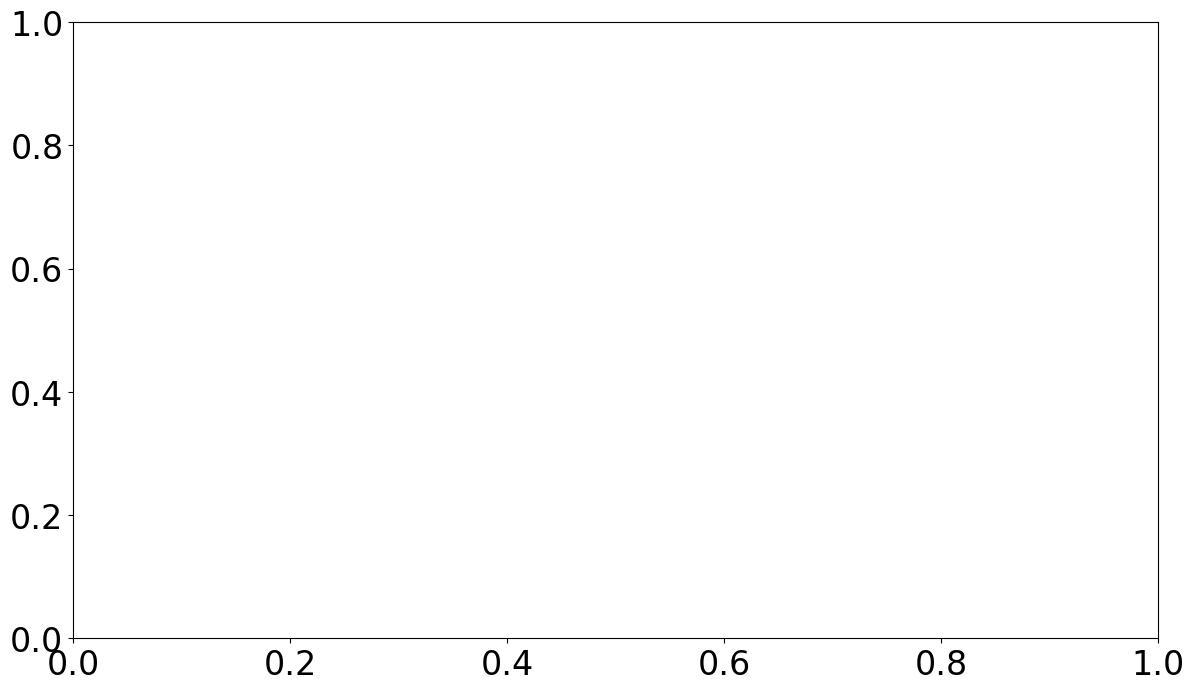

In [2]:
import pandas as pd
import numpy as np
from datetime import datetime, date, timedelta
import matplotlib.pyplot as plt

EXTRACTED_DATA_PATH = "../../data/extracted"
OUTPUT_DATA_DIR = "../../data/processed"

colors = plt.cm.get_cmap('hsv', 50)

# Read data
csv_google = pd.read_csv(f'{EXTRACTED_DATA_PATH}/nsl_letters_google.csv')
csv_apple = pd.read_csv(f'{EXTRACTED_DATA_PATH}/nsl_letters_apple.csv')
csv_nslarchive = pd.read_csv(f'{EXTRACTED_DATA_PATH}/nsl_letters_nslarchive.csv')
csv = pd.concat([csv_google, csv_apple, csv_nslarchive])

# earlier date when the letter is served
csv['nsl_issue_dates'] = nsl_issue_dates = [datetime.strptime(val, "%Y-%m-%d") for val in csv['issue date'].values]

# later date when the letter is published
csv['nsl_release_dates'] = nsl_release_dates = [datetime.strptime(val, "%Y-%m-%d") for val in csv['release date'].values]

# proxy for gag order time: difference between issue and release dates
gag_time = [(nsl_release_dates[i] - nsl_issue_dates[i]).days for i in range(len(nsl_release_dates))]

# Sort nsls by issue dates
nsl_issue_dates_zip_gag_time = zip(nsl_issue_dates, gag_time)
nsl_issue_dates_zip_gag_time_s = sorted(nsl_issue_dates_zip_gag_time, key=lambda x: x[0])
nsl_issue_dates_s, gag_time_s = zip(*nsl_issue_dates_zip_gag_time_s)
gag_time_s = [float(ss) for ss in gag_time_s]

# Create pandas frame for the inferred gag time over issue dates 
gag_time_over_issue_date_df = pd.DataFrame({'nsl_issue_dates' : nsl_issue_dates_s, 'gag_time' : gag_time_s}, columns=['nsl_issue_dates', 'gag_time'])

# Aggregate the data per year, compute the mean, minimum, and maximum for every year
gag_time_over_issue_date_df__year = gag_time_over_issue_date_df.groupby(gag_time_over_issue_date_df.nsl_issue_dates.dt.year).mean()
gag_time_over_issue_date_df__year_min = gag_time_over_issue_date_df.groupby(gag_time_over_issue_date_df.nsl_issue_dates.dt.year).min()
gag_time_over_issue_date_df__year_max = gag_time_over_issue_date_df.groupby(gag_time_over_issue_date_df.nsl_issue_dates.dt.year).max()

# Plot the gag order time
plt.rc("axes", axisbelow=True)
plt.rcParams["font.size"] = 24
plt.rcParams["mathtext.default"] = "regular"
plt.rcParams["figure.figsize"] = (14,8)
plt.ticklabel_format(style='plain')

colors_wong = [
    "#000000", "#e69f00", "#56b4e9", "#009e73",
    "#f0e442", "#0072b2", "#d55e00", "#cc79a7"
]

Use degree 20 polyfit


/tmp/ipykernel_96457/3127973171.py:49: RankWarning: Polyfit may be poorly conditioned
  coeffs = np.polyfit(xs_ordinal, np.array(ys_ordinal), deg=deg)


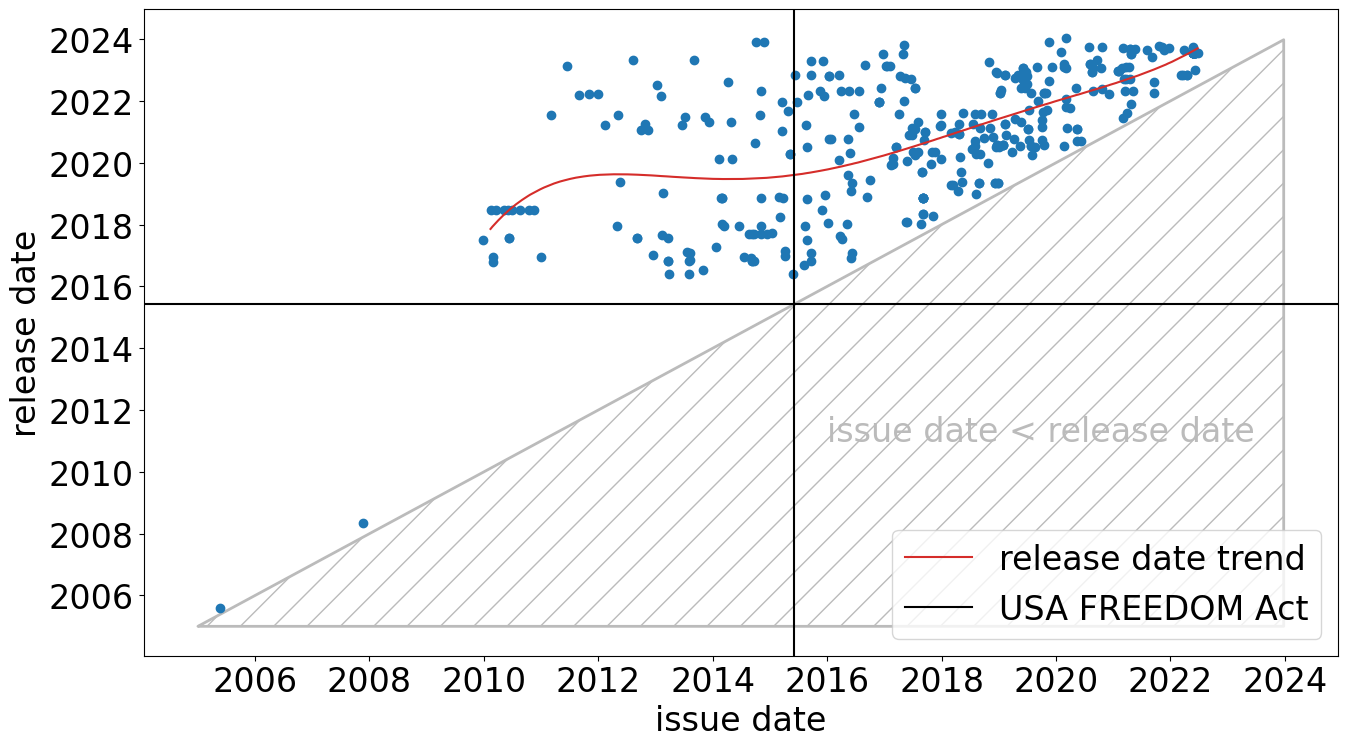

In [3]:
import numpy as np
from copy import deepcopy

plt.rc("axes", axisbelow=False)
plt.rcParams["font.size"] = 24
plt.rcParams["mathtext.default"] = "regular"
plt.rcParams["figure.figsize"] = (14,8)

# diagonal to show dead triangle
nsl_release_dates_min = datetime(year=2005, month=1, day=1)
nsl_release_dates_max = datetime(year=2024, month=1, day=1)
x_values = np.arange(nsl_release_dates_min, nsl_release_dates_max, (nsl_release_dates_max - nsl_release_dates_min)/1000)
bottom_line = [nsl_release_dates_min] * len(x_values)
# plt.plot(x_values, x_values, color="#d52d2a")

plt.fill_between(x_values, bottom_line, x_values, edgecolor="#bbbbbb", facecolor="none", linewidth=2, hatch="/")
mid = nsl_release_dates_min + (nsl_release_dates_max - nsl_release_dates_min)/4
plt.text(datetime(year=2016, month=1, day=1), datetime(year=2011, month=1, day=1), "issue date < release date", color="#bbbbbb")

plt.tight_layout()
plt.savefig(f"{OUTPUT_DATA_DIR}/issue_release_scatter_plot_triangle.pdf")
plt.savefig(f"{OUTPUT_DATA_DIR}/issue_release_scatter_plot_triangle.png")

# scatter plot with dots for every release/issue date
plt.scatter(nsl_issue_dates, nsl_release_dates)

plt.tight_layout()
plt.savefig(f"{OUTPUT_DATA_DIR}/issue_release_scatter_plot_scatter_points.pdf")
plt.savefig(f"{OUTPUT_DATA_DIR}/issue_release_scatter_plot_scatter_points.png")

# Trend line
def to_ordinal(xs):
    return list(map(lambda x: x.toordinal(), xs))

def from_ordinal(xs):
    return list(map(lambda x: datetime.fromordinal(int(x)), xs))

def poly_regression(xs_ts, ys_ts, deg=1):
    """
    Compute regression on xs, ys with polynomial of degree `deg`
    (for deg=1, this computes the linear regression)
    """                               

    xs_ordinal = to_ordinal(xs_ts)
    ys_ordinal = to_ordinal(ys_ts)

    print(f"Use degree {deg} polyfit")
    x_vals = np.array(xs_ordinal)
    coeffs = np.polyfit(xs_ordinal, np.array(ys_ordinal), deg=deg)
    new_xs_ordinal = np.linspace(min(xs_ordinal), max(xs_ordinal), len(x_vals))
    new_ys_ordinal = []
    for x in new_xs_ordinal:
        y = 0
        for i, coeff in enumerate(coeffs):
            y += x**(deg-i) * coeff
        new_ys_ordinal.append(y)

    new_xs_ordinal = from_ordinal(new_xs_ordinal)
    new_ys_ordinal = from_ordinal(new_ys_ordinal)

    return new_xs_ordinal, new_ys_ordinal

# Remove early outliers before plotting trend
nsl_issue_dates_trend = []
nsl_release_dates_trend = []
for i, issue_date in enumerate(nsl_issue_dates):
    if issue_date.year >= 2010:
        nsl_issue_dates_trend.append(issue_date)
        nsl_release_dates_trend.append(nsl_release_dates[i])

trend_issue_date, trend_release_date = poly_regression(nsl_issue_dates_trend, nsl_release_dates_trend, deg=20)
plt.plot(trend_issue_date, trend_release_date, color="#d52d2a", label="release date trend")

plt.tight_layout()
plt.legend()
plt.savefig(f"{OUTPUT_DATA_DIR}/issue_release_scatter_plot_trend.pdf")
plt.savefig(f"{OUTPUT_DATA_DIR}/issue_release_scatter_plot_trend.png")

# Add FREEDOM Act line
plt.axhline(y=datetime(year=2015, month=6, day=2), color=colors_wong[0], linestyle='-', label="USA FREEDOM Act")
plt.axvline(x=datetime(year=2015, month=6, day=2), color=colors_wong[0], linestyle='-')

plt.xlabel("issue date")
plt.ylabel("release date")
plt.legend(loc="lower right")
plt.tight_layout()
plt.savefig(f"{OUTPUT_DATA_DIR}/issue_release_scatter_plot.pdf")
plt.savefig(f"{OUTPUT_DATA_DIR}/issue_release_scatter_plot.png")

Use degree 10 polyfit


/tmp/ipykernel_96457/465122286.py:72: RankWarning: Polyfit may be poorly conditioned
  coeffs = np.polyfit(xs_ordinal, np.array(ys), deg=deg)
/tmp/ipykernel_96457/465122286.py:138: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '2011-02-17' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  csv_simulated_const.loc[i, 'issue date'] = date_i.strftime("%Y-%m-%d")
/tmp/ipykernel_96457/465122286.py:139: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '2016-10-18' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  csv_simulated_const.loc[i, 'release date'] = date_p.strftime("%Y-%m-%d")


Use degree 10 polyfit


/tmp/ipykernel_96457/465122286.py:72: RankWarning: Polyfit may be poorly conditioned
  coeffs = np.polyfit(xs_ordinal, np.array(ys), deg=deg)


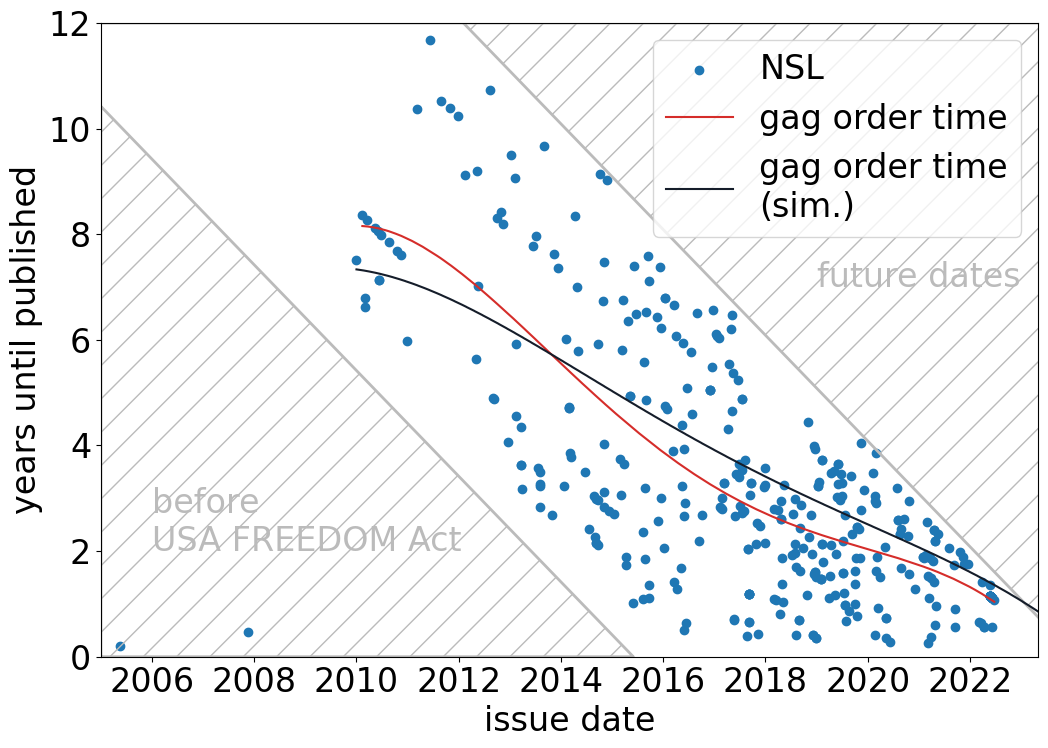

In [10]:
import numpy as np
from random import randrange
import random

plt.rc("axes", axisbelow=False)
plt.rcParams["font.size"] = 24
plt.rcParams["mathtext.default"] = "regular"
plt.rcParams["figure.figsize"] = (11,8)

plt.xlabel("issue date")
plt.ylabel("years until published")

def to_ordinal(xs):
    return list(map(lambda x: x.toordinal(), xs))

def from_ordinal(xs):
    return list(map(lambda x: datetime.fromordinal(int(x)), xs))

gag_time_in_years = [t / 365 for t in gag_time]

issue_date_min = datetime(year=2005, month=1, day=1)

# scatter plot with dots for every release/issue date
plt.scatter(nsl_issue_dates, gag_time_in_years, label="NSL")

plt.xlim(issue_date_min)
plt.ylim(0, 12)
plt.legend(loc="upper right")
plt.tight_layout()
plt.savefig(f"{OUTPUT_DATA_DIR}/gag_order_time_until_published_dots.png")

# Add FREEDOM Act triangle to show which NSLs were published after the FREEDOM act
freedom_act_date = datetime(year=2015, month=6, day=2)
def freedom_line(x):
    return (freedom_act_date - x).days / 365

freedom_act_issue_dates = from_ordinal(np.linspace(issue_date_min.toordinal(), freedom_act_date.toordinal(), 1000))
freedom_act_y_axis_data_point = [freedom_line(issue_date) for issue_date in freedom_act_issue_dates]
# plt.plot(freedom_act_issue_dates, freedom_act_y_axis_data_point, color=colors_wong[0], linestyle='-', label="USA FREEDOM Act")

bottom_line = [0] * len(freedom_act_issue_dates)
plt.fill_between(freedom_act_issue_dates, bottom_line, freedom_act_y_axis_data_point, edgecolor="#bbbbbb", facecolor="none", linewidth=2, hatch="/")
plt.text(datetime(year=2006, month=1, day=1), 2, "before\nUSA FREEDOM Act", color="#bbbbbb")

# Add future triangle to show which dates are in the future
last_analyzed_date = datetime(year=2024, month=2, day=1)
def future_line(x):
    return (last_analyzed_date - x).days / 365

future_issue_dates = from_ordinal(np.linspace(issue_date_min.toordinal(), last_analyzed_date.toordinal(), 1000))
future_y_axis_data_point = [future_line(issue_date) for issue_date in future_issue_dates]

top_line = [12] * len(future_issue_dates)
plt.fill_between(future_issue_dates, top_line, future_y_axis_data_point, edgecolor="#bbbbbb", facecolor="none", linewidth=2, hatch="/")
plt.text(datetime(year=2019, month=1, day=1), 7, "future dates", color="#bbbbbb")

plt.legend(loc="upper right")
plt.tight_layout()
plt.savefig(f"{OUTPUT_DATA_DIR}/gag_order_time_until_published_freedom.png")

# Trend line
def poly_regression(xs_ts, ys, deg=1):
    """
    Compute regression on xs, ys with polynomial of degree `deg`
    (for deg=1, this computes the linear regression)
    """                               

    xs_ordinal = to_ordinal(xs_ts)

    print(f"Use degree {deg} polyfit")
    x_vals = np.array(xs_ordinal)
    coeffs = np.polyfit(xs_ordinal, np.array(ys), deg=deg)
    new_xs_ordinal = np.linspace(min(xs_ordinal), max(xs_ordinal), len(x_vals))
    new_ys = []
    for x in new_xs_ordinal:
        y = 0
        for i, coeff in enumerate(coeffs):
            y += x**(deg-i) * coeff
        new_ys.append(y)

    new_xs_ordinal = from_ordinal(new_xs_ordinal)

    return new_xs_ordinal, new_ys

# Remove early outliers before plotting trend
nsl_issue_dates_trend = []
gag_time_in_years_trend = []
for i, issue_date in enumerate(nsl_issue_dates):
    if issue_date.year >= 2010:
        nsl_issue_dates_trend.append(issue_date)
        gag_time_in_years_trend.append(gag_time_in_years[i])

trend_issue_date, trend_release_date = poly_regression(nsl_issue_dates_trend, gag_time_in_years_trend, deg=10)
plt.plot(trend_issue_date, trend_release_date, color="#d52d2a", label="gag order time")


# simulation

def random_date(start, end):
    delta = end - start
    int_delta = (delta.days * 24 * 60 * 60) + delta.seconds
    random_second = randrange(int_delta)
    return start + timedelta(seconds=random_second)

def plot_simulation(csv_sim, label):
    csv_sim['nsl_issue_dates'] = nsl_issue_dates_sim = [datetime.strptime(val, "%Y-%m-%d") for val in csv_sim['issue date'].values]
    csv_sim['nsl_release_dates'] = nsl_release_dates_sim = [datetime.strptime(val, "%Y-%m-%d") for val in csv_sim['release date'].values]
    gag_time_sim = [(nsl_release_dates_sim[i] - nsl_issue_dates_sim[i]).days for i in range(len(nsl_release_dates_sim))]
    gag_time_in_years_sim = [t / 365 for t in gag_time_sim]
    nsl_issue_dates_trend_sim = []
    gag_time_in_years_trend_sim = []
    for i, issue_date in enumerate(nsl_issue_dates_sim):
        if issue_date.year >= 2010:
            nsl_issue_dates_trend_sim.append(issue_date)
            gag_time_in_years_trend_sim.append(gag_time_in_years_sim[i] )
    #plt.scatter(nsl_issue_dates_trend_sim, gag_time_in_years_trend_sim)
    trend_issue_date_sim, trend_release_date_sim = poly_regression(nsl_issue_dates_trend_sim, gag_time_in_years_trend_sim, deg=10)
    plt.plot(trend_issue_date_sim, trend_release_date_sim, color="#151d2a", label=label)

data_mp = 8
csv_simulated_const = csv.copy()
csv_simulated_const = pd.concat([csv_simulated_const] * data_mp, ignore_index=True)
csv_simulated_const['issue date'] = 0
csv_simulated_const['release date'] = 0
csv_simulated_const['nsl_issue_dates'] = 0
csv_simulated_const['nsl_release_dates'] = 0
d1 = datetime.strptime('1/1/2008 1:30 PM', '%m/%d/%Y %I:%M %p')
d2 = datetime.strptime('3/1/2024 1:00 AM', '%m/%d/%Y %I:%M %p')
i = 0
N = 12*10
while i < len(csv_simulated_const):
   date_i = random_date(d1, d2)
   gag_duration_months = random.randint(0, N)
   date_p = date_i + timedelta(seconds=gag_duration_months * 30 * 24 * 60 * 60)
   if date_p.date() > datetime.today().date() or date_p.date() < freedom_act_date.date():
    i = i
   else:
    csv_simulated_const.loc[i, 'issue date'] = date_i.strftime("%Y-%m-%d")
    csv_simulated_const.loc[i, 'release date'] = date_p.strftime("%Y-%m-%d")
    i += 1
plot_simulation(csv_simulated_const, label="gag order time\n(sim.)")

plt.legend()
plt.tight_layout()
plt.savefig(f"{OUTPUT_DATA_DIR}/gag_order_time_until_published.pdf")
plt.savefig(f"{OUTPUT_DATA_DIR}/gag_order_time_until_published.png")
plt.savefig(f"{OUTPUT_DATA_DIR}/gag_order_time_until_published.jpg")

/tmp/ipykernel_96457/3953741625.py:3: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  plt.errorbar([datetime(v, 6, 1) for v in gag_time_over_issue_date_df__year.index.values], gag_time_over_issue_date_df__year['gag_time'].values.tolist(),


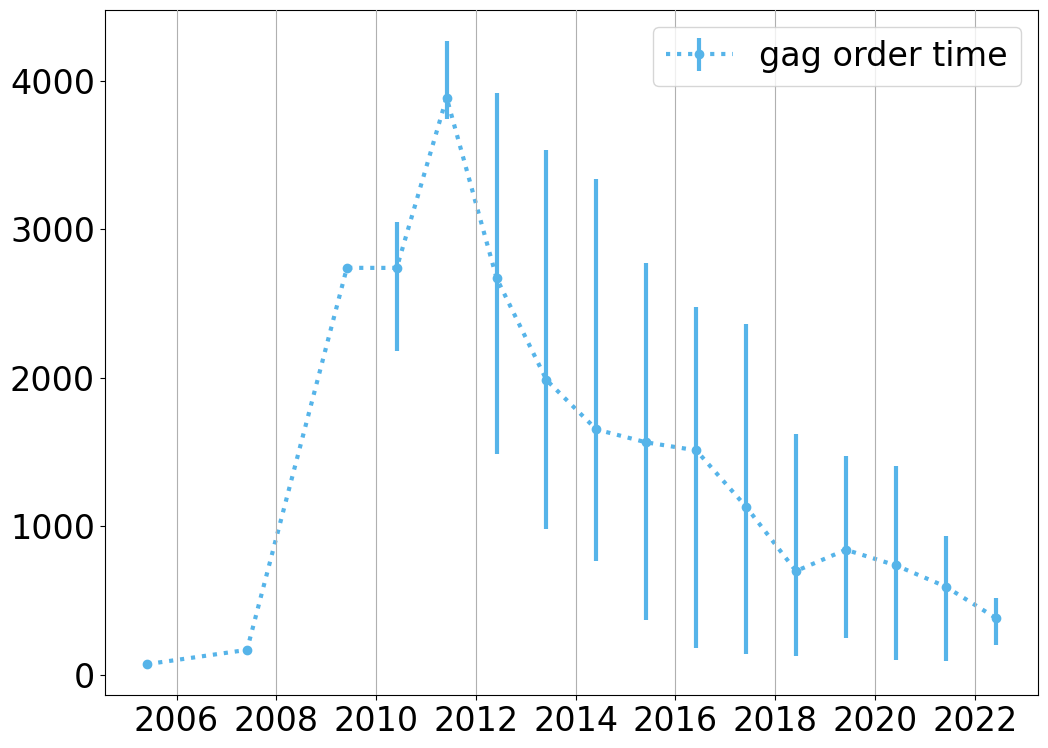

In [5]:
# Paper plot

plt.errorbar([datetime(v, 6, 1) for v in gag_time_over_issue_date_df__year.index.values], gag_time_over_issue_date_df__year['gag_time'].values.tolist(),
   yerr =  (np.array(gag_time_over_issue_date_df__year['gag_time' ].values.tolist()) - np.array(gag_time_over_issue_date_df__year_min['gag_time'].values.tolist()),
            np.array(gag_time_over_issue_date_df__year_max['gag_time' ].values.tolist()) - np.array(gag_time_over_issue_date_df__year['gag_time'].values.tolist())),
   linestyle='dotted', marker='o', label="gag order time", color="#56b4e9", fmt='o', elinewidth=3, linewidth=3)

plt.grid(True, which="major")
plt.grid(True, which="minor")
plt.grid(axis="y")
plt.legend()                                                                                                                                                                        
plt.xlabel(None)
plt.ylabel(None)
plt.legend()
plt.tight_layout()
plt.savefig(f"{OUTPUT_DATA_DIR}/mean_gag_time_over_time_yearly_date_let__errorbar.pdf")
plt.savefig(f"{OUTPUT_DATA_DIR}/mean_gag_time_over_time_yearly_date_let__errorbar.png")

/tmp/ipykernel_96457/3580830265.py:10: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  plt.errorbar([datetime(v, 6, 1) for v in gag_time_over_issue_date_df__year.index.values], gag_time_over_issue_date_df__year['gag_time'].values.tolist(),


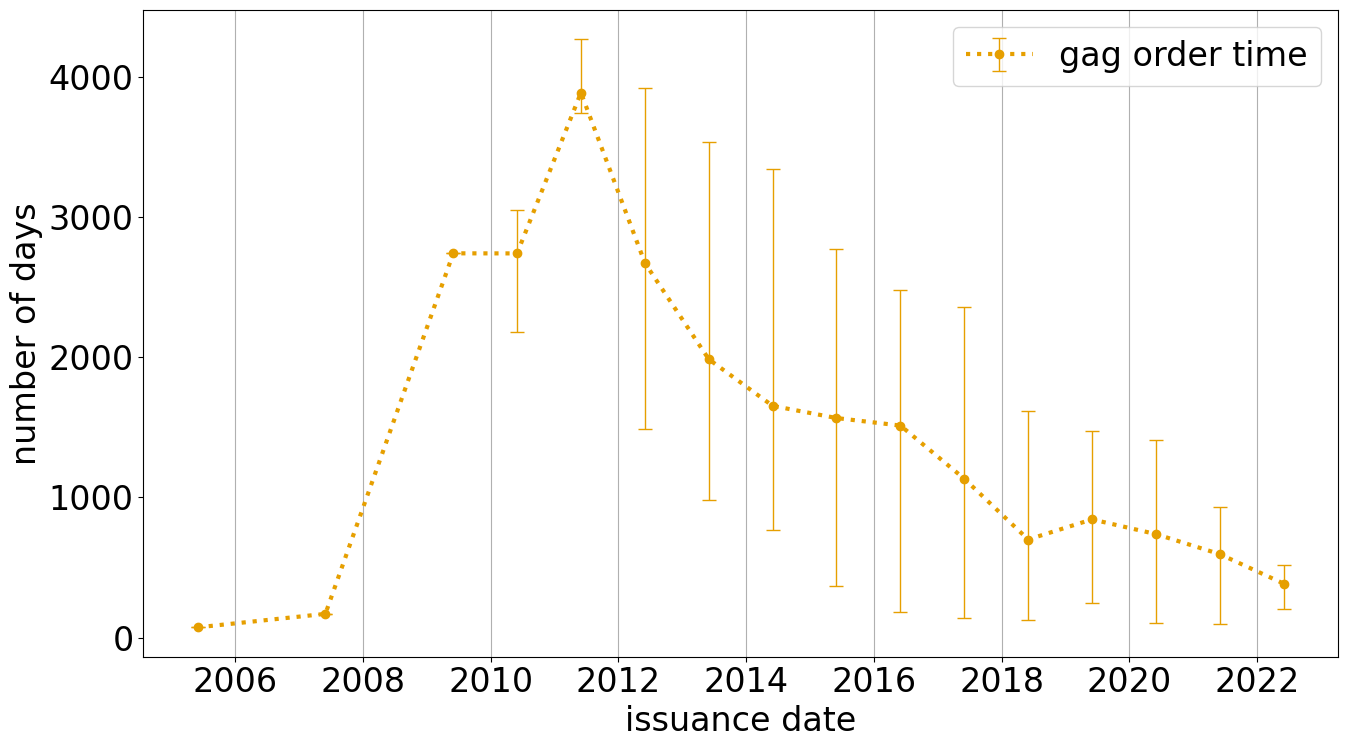

In [6]:
# Presentation plot

# Plot the gag order time
plt.rc("axes", axisbelow=True)
plt.rcParams["font.size"] = 24
plt.rcParams["mathtext.default"] = "regular"
plt.rcParams["figure.figsize"] = (14,8)
plt.ticklabel_format(style='plain')

plt.errorbar([datetime(v, 6, 1) for v in gag_time_over_issue_date_df__year.index.values], gag_time_over_issue_date_df__year['gag_time'].values.tolist(),
   yerr =  (np.array(gag_time_over_issue_date_df__year['gag_time' ].values.tolist()) - np.array(gag_time_over_issue_date_df__year_min['gag_time'].values.tolist()),
            np.array(gag_time_over_issue_date_df__year_max['gag_time' ].values.tolist()) - np.array(gag_time_over_issue_date_df__year['gag_time'].values.tolist())),
   linestyle='dotted', marker='o', label="gag order time", color="#e69f00", fmt='o', elinewidth=1, linewidth=3, capsize=5)

plt.grid(True, which="major")
plt.grid(True, which="minor")
plt.grid(axis="y")
plt.xlabel("issuance date")
plt.ylabel("number of days")
plt.legend()    
plt.tight_layout()
plt.savefig(f"{OUTPUT_DATA_DIR}/mean_gag_time_over_time_yearly_date_let__errorbar.pdf")
plt.savefig(f"{OUTPUT_DATA_DIR}/mean_gag_time_over_time_yearly_date_let__errorbar.png")

In [7]:
import pandas as pd
import numpy as np
from datetime import datetime, date, timedelta
import matplotlib.pyplot as plt
from random import randrange
from datetime import timedelta
import random
from tqdm import tqdm
from pprint import pprint

plt.rcParams["figure.figsize"] = (8,6)
plt.figure()
plt.xlabel(r"$a$, date issued", position=(0.75,-10), fontsize=16, horizontalalignment='left', verticalalignment='top')
plt.ylabel(r"$b$, years until published", position=(0,1), fontsize=16, horizontalalignment='right', verticalalignment='bottom')
plt.ylim(bottom=0, top=2)
plt.xlim(left=0, right=4.8)
plt.legend()
#plt.tight_layout()
plt.xticks([])
plt.yticks([])

a_1 = 2
plt.axvline(x=a_1, color='black', linestyle='--')
plt.annotate(r"$a_1$", xy=(a_1, 0), xytext=(a_1-0.07, -0.15),
    arrowprops=dict(facecolor='black', arrowstyle='-'))

k = 3
k_a_x = [0, 3]
k_a_y = [k - a for a in k_a_x]

plt.plot(k_a_x, k_a_y, color='black', linestyle='-', label=r"$k - a$")
plt.annotate(r"$k$", xy=(k, 0), xytext=(k-0.004, -0.15),
    arrowprops=dict(facecolor='black', arrowstyle='-'))
plt.annotate(r"$k - a$", xy=(k-0.5, 0.5), xytext=(k-0.5 + 0.02, 0.5 + 0.02))

plt.axvline(x=0.5, color='black', linestyle='solid', linewidth=1.5)

plt.annotate('', xy=(0.5, 0), xytext=(0.5, 2),
             arrowprops=dict(facecolor='black', arrowstyle='->', mutation_scale=30))
plt.annotate('', xy=(0.5, 2), xytext=(0.5, 0),
            arrowprops=dict(facecolor='black', arrowstyle='->', mutation_scale=30))
plt.annotate(r"$N$", xy=(0.5 + 0.05, 1), xytext=(0.5 + 0.05, 1))

plt.annotate('', xy=(0, 2), xytext=(0, 0),
             arrowprops=dict(facecolor='black', arrowstyle='->', linewidth=2, mutation_scale=30))
plt.annotate('', xy=(4.8, 0), xytext=(0, 0),
             arrowprops=dict(facecolor='black', arrowstyle='->', linewidth=2, mutation_scale=30))


plt.savefig(f"{OUTPUT_DATA_DIR}/gibbs_graph.png")
plt.savefig(f"{OUTPUT_DATA_DIR}/gibbs_graph.pdf")
plt.show()

ModuleNotFoundError: No module named 'tqdm'